<a href="https://colab.research.google.com/github/DanielHolzwart/MNIST/blob/main/MNIST_nn_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/MNIST

Mounted at /content/drive
/content/drive/MyDrive/Kaggle/MNIST


In [3]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('train.csv')

In [4]:
X_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = X_train['label']
X_train = X_train.drop('label', axis = 1)
len(X_train)

42000

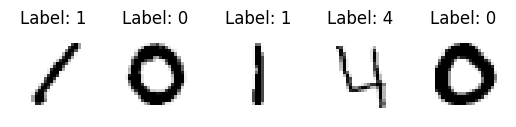

In [6]:
#plot a few images (five)
import matplotlib.pyplot as plt
rng_plt = range(5)
for i in rng_plt:
  digit = X_train.loc[i].to_numpy().reshape(28,28)
  plt.subplot(1,len(rng_plt),i+1)
  plt.imshow(digit,cmap= plt.cm.binary)
  plt.axis('off')
  plt.title(f'Label: {y_train[i]}')

plt.show()

In [7]:
#let us now split the data into a test and validation set. The following code overwrites the training set
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size = 0.2,shuffle = True, random_state = 1)
print(f'Length of train set {len(X_train)} and length of validation set {len(X_valid)}')

Length of train set 33600 and length of validation set 8400


Next we will set up a neural network to classify the digits. We start with a fully connected one and then turn out attention to a convnet.

**1. Fully connected network**

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [20]:
#create tensors
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
X_valid_tensor = torch.tensor(X_valid.values)
y_valid_tensor = torch.tensor(y_valid.values)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle= True)

In [9]:
#create NN. Cross entropy as we have multiple output and the Adam optimizer is usually a suitable choice in image detection. The input imagizes are of size 28 x 28
import torch.nn as nn

model = nn.Sequential(nn.Linear(28*28,512),nn.ReLU(),nn.Linear(512,10))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [26]:
#train the network. We will reuse the code from the titanic_nn
num_epochs = 10
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] += loss.item()
    accuracy_hist_train[epoch] /= len(train_dl.dataset)
    loss_hist_train[epoch] /= len(train_dl.dataset)
    pred = model(X_valid_tensor.float())
    loss = loss_fn(pred,y_valid_tensor)
    loss_hist_valid[epoch] = loss.item()
    is_correct = (torch.argmax(pred, dim=1) == y_valid_tensor).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

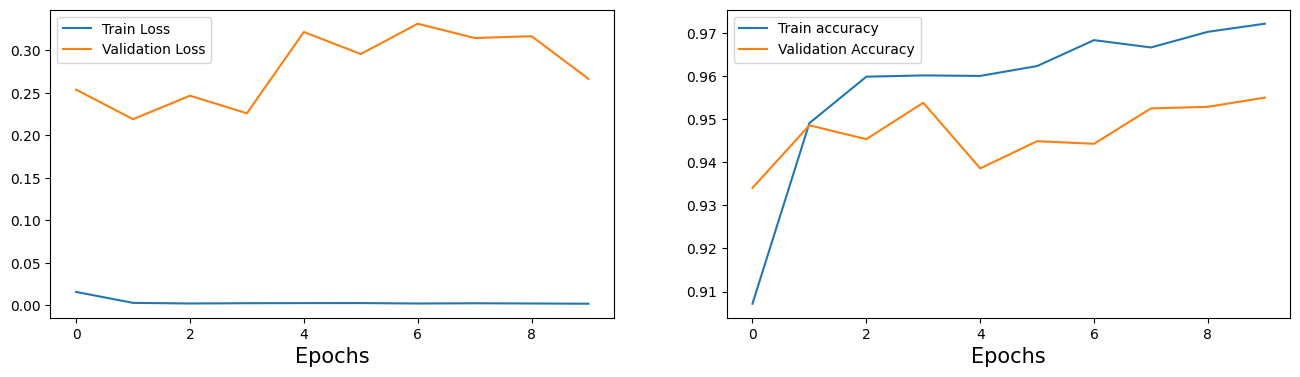

In [27]:
#plot the results of accuracy and loss
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(loss_hist_train)
plt.plot(loss_hist_valid)
plt.legend(['Train Loss','Validation Loss'])
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(accuracy_hist_train)
plt.plot(accuracy_hist_valid)
ax.set_xlabel('Epochs', size = 15)
plt.legend(['Train accuracy','Validation Accuracy'])
plt.show()

In [153]:
#let us look at the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score
confusion_matrix(y_train.to_numpy(), torch.argmax(model(X_train_tensor.float()),dim = 1).detach().numpy())

array([[1517,    0,    1,    0,  455,    0,    0, 1302,    1,    3],
       [1345,    0,    0,    0,    7,    0,    0, 1548,    0,  844],
       [1439,    7,    1,    7,   60,    2,    0, 1751,    0,   75],
       [2026,    1,    6,    0,   44,    3,    0, 1311,   14,   73],
       [ 941,    3,   10,   11,   57,   42,    0, 2109,   59,   11],
       [1167,    6,   18,    3,  180,    1,    0, 1655,   22,   12],
       [1478,    8,   30,   16,  284,    2,    0, 1441,    1,   77],
       [ 833,    1,    0,    1,  154,    4,    0, 2520,   25,   13],
       [1426,   18,    0,    2,   18,    0,    0, 1745,    1,    7],
       [1203,    8,   11,   16,   66,    3,    0, 1991,   38,    9]])

The model is not working any better than the classical machine learning algorithms like KNeighbors or RandomForest. Before putting any addtional work into parameter tuning, let us have a look onto a cnn first.

**2. Convolutinal neural network**

In [32]:
#to contruct a cnn it is usually a valid approach to have increasing channel size while the width and heigth shrinks
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2)) #padding = 2 means that the output is input size
model.add_module('relu1',nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2)) #kernel size 2 halfs the spatial dimensions
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2))
model.add_module('relu2',nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))


In [33]:
#calculate size of feature maps
x = torch.ones([4,1,308,308])
model(x).shape

torch.Size([4, 64, 77, 77])

In [34]:
#flattening the last layer to a fully connected neural network
model.add_module('flatten',nn.Flatten())
x = torch.ones([4,1,28,28])
print(model(x).shape)

model.add_module('fc1',nn.Linear(64*7*7,1024))
model.add_module('relu3',nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2',nn.Linear(1024,10))


torch.Size([4, 3136])


In [35]:
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [36]:
model(x).shape

torch.Size([4, 10])

In [37]:
#we need to bring the train and validation data into the appropiate form NCHW (=Number of images / channls / height / width)
X_train_expand = np.resize(X_train, (len(X_train),1,28,28))
X_valid_expand = np.resize(X_valid, (len(X_valid),1,28,28))

In [38]:
X_train_expand.shape

(33600, 1, 28, 28)

In [39]:
X_train_tensor2 = torch.tensor(X_train_expand)
X_valid_tensor2 = torch.tensor(X_valid_expand)

train_ds = TensorDataset(X_train_tensor2, y_train_tensor)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle= True)

In [40]:
#same code as above but now with the cnn
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 5
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] += loss.item()
    accuracy_hist_train[epoch] /= len(train_dl.dataset)
    loss_hist_train[epoch] /= len(train_dl.dataset)
    pred = model(X_valid_tensor2.float())
    loss = loss_fn(pred,y_valid_tensor)
    loss_hist_valid[epoch] = loss.item()
    is_correct = (torch.argmax(pred, dim=1) == y_valid_tensor).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

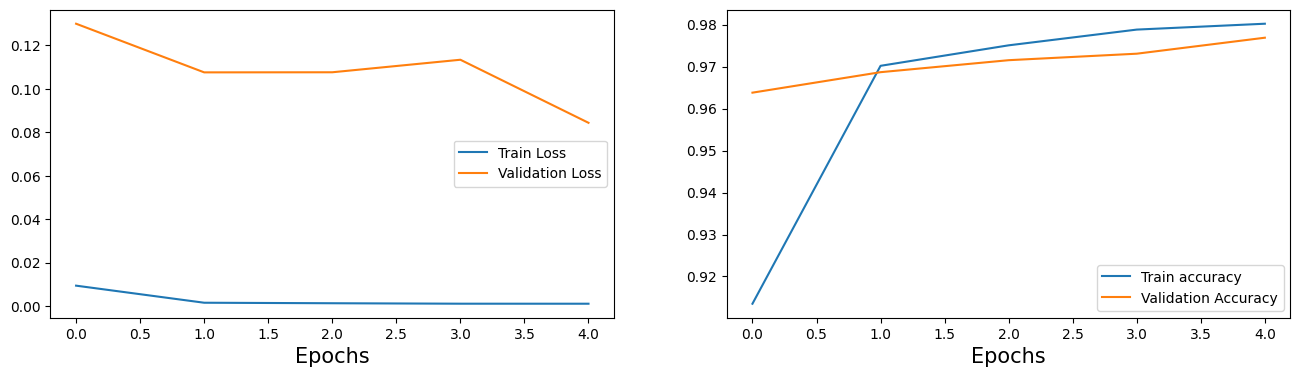

In [41]:
#plot the results of accuracy and loss
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(loss_hist_train)
plt.plot(loss_hist_valid)
plt.legend(['Train Loss','Validation Loss'])
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(accuracy_hist_train)
plt.plot(accuracy_hist_valid)
ax.set_xlabel('Epochs', size = 15)
plt.legend(['Train accuracy','Validation Accuracy'])
plt.show()

The result looks more promising but the amount of epochs are limited due to resources